## Fitting Sigmoid to empirical NN
### Manually selecting bin size

In [18]:
# 9 Species: AT, CE, DM, ...
# 8 Classes: ER, ERDD, GEO, GEOGD ...(each with ~500 data points)
# normalization is done on each species seperetaly.
'''
try adding list of every sigmoid functions not just arctan_gd
'''

'\ntry adding list of every sigmoid functions not just arctan_gd\n'

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import erf
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FormatStrFormatter

### normalization on AT,CE

In [20]:
classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky', 'Original']
classes_pred = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky']
#data_locations = [r"/content/drive/MyDrive/random stuff/Adaptable-Sigmoids/data/AT"+c for c in classes]
data_locations = [r"/Users/lizongli/Desktop/knn research/Adaptable-Sigmoids/data/AT"+c for c in classes]
#data_locations_CE = [r"/content/drive/MyDrive/random stuff/Adaptable-Sigmoids/data/CE"+c for c in classes]
data_locations_CE = [r"/Users/lizongli/Desktop/knn research/Adaptable-Sigmoids/data/CE"+c for c in classes]
#prediction_p_value = "/content/drive/MyDrive/random stuff/Adaptable-Sigmoids/data/ATOriginal"
prediction_p_value = "Users/lizongli/Desktop/knn research/Adaptable-Sigmoids/data/ATOriginal"

In [21]:
# from google.colab import drive
# drive.mount('/content/drive')

In [22]:
def combine_data(data_location,classes):
    df_comb = pd.DataFrame()
    i = 0
    for protein in data_location:
        df = pd.read_csv(protein, header = None, sep = ' ')
        # print(df.head)
        # print(df['class'])
        df['class'] = classes[i]
        # print(classes[i])
        df_comb = pd.concat([df, df_comb])
        # print(df.head)
        # print("------")
        i += 1
    return df_comb

In [23]:
# def combine_data1(data_list, classes):
#     df_comb = pd.DataFrame()
#     i = 0
#     for df in data_list:
#         df['class'] = classes[i]
#         df_comb = pd.concat([df, df_comb])
#         i += 1
#     return df_comb

In [24]:
# # df_comb = combine_data(["/Users/lizongli/Desktop/knn research/Adaptable-Sigmoids/data/ATER", "/Users/lizongli/Desktop/knn research/Adaptable-Sigmoids/data/ATOriginal"], ["ER", "Original"])
# d1 = pd.read_csv("/Users/lizongli/Desktop/knn research/Adaptable-Sigmoids/data/ATER")
# d2 = pd.read_csv("/Users/lizongli/Desktop/knn research/Adaptable-Sigmoids/data/ATOriginal")
# df_comb1 = combine_data1([d1, d2], ["ER", "Orginal"])

In [25]:
# df_comb = combine_data(data_locations,classes)
df_comb = combine_data(["/Users/lizongli/Desktop/knn research/Adaptable-Sigmoids/data/ECHGG", "/Users/lizongli/Desktop/knn research/Adaptable-Sigmoids/data/ECOriginal"], ["HGG", "Original"])
# print(df_comb.head)
df_class = df_comb['class']
df_comb = df_comb.drop("class", axis = 1)
# print(df_comb.head)
df_comb = pd.DataFrame(MinMaxScaler().fit_transform(df_comb))
df_comb['class'] = df_class.reset_index(drop = True)

# df_comb["class"]

# df_class = df_comb1['class']
# # print(df_comb1.head)
# df_comb1 = df_comb1.drop("class", axis = 1)
# print(df_comb1.head)
# df_comb1 = pd.DataFrame(MinMaxScaler().fit_transform(df_comb1))
# df_comb1['class'] = df_class.reset_index(drop = True)

In [26]:
df_CE = combine_data(data_locations_CE,classes)
df_class_CE = df_CE['class']
df_CE = df_CE.drop("class", axis = 1)
df_CE = pd.DataFrame(MinMaxScaler().fit_transform(df_CE))
df_CE['class'] = df_class_CE.reset_index(drop = True)

In [27]:
# calling data(data_frame, class_name) return Species-Class empirical data as an array
def data(dataframe, class_name):
    return dataframe[dataframe['class']==class_name].drop("class",axis=1).to_numpy()

### helper functions

In [28]:
# calculating empirical data's shortest(NN) distance 
# real data is high-dimensional data points
def data_distance(data):
    shortest_distance = [0]*len(data)
    for i in range(len(data)):
        x = np.delete(data,i,0)
        temp = (x-data[i])**2
        d = np.sqrt(np.sum(temp,axis=1))
        shortest_distance[i] = d.min()
    
    return np.array(shortest_distance)   # return an array of real data's NN distance


# plotting empirical data's NN hist
def plot_data_distance(D, title):
    """
    D: an array of real data' NN distance
    """
    f, ax = plt.subplots(1,1, figsize = (6,4))
    ax.hist(D,edgecolor='white',bins=100)   ## consider specifying <bins>
    ax.set_title(title)
    plt.show()
    return


# generate empirical CDF manually, satisfying:
# 1. F(x<=0) = 0
# 2. F(x_1) = 1/(n+1)
# 3. F(x_n/2) = 0.5
# 4. F(x_n) = n/(n+1)
# 5. F(x) < 1 for all x.
def empirical_CDF(data,title):
    '''
    return x,y data of CDF 
    '''    
    sort_data = np.sort(data)
    #print("data len: ",len(sort_data))
    x = np.concatenate(([0],sort_data))
    #print("x len : ",len(x))
    #print("first: ", x[0], "\nlast: ",x[-1])
    
    y = np.zeros((x.shape))
    for i in range(1,len(x)):
        y[i] = i/len(x)
    #print(plt.show())
    return x,y



# curve_fit()
def auto_curve_fit(data_NN, x, y, x_scale_factor, func, s, p_control=None):
    '''
    data_NN: array empirical data_distance for calculating median
    x,y: from CDF
    s: sigma in curve_fit(), for weighting
    '''
    if p_control == "Gompertz":
        p0 = [1,1]
    elif p_control == "Weight":
        p0 = [np.median(data_NN)/x_scale_factor,1,0.5]
    else:
        p0 = [np.median(data_NN)/x_scale_factor,1] # this is initial guess for sigmoid parameters
    
    popt, pcov = curve_fit(f=func, xdata=x/x_scale_factor, ydata=y, p0=p0,method='lm')

    # parameters yielded by Curve_fit: x0, k
    print("curve_fit parameter on "+str(func)[9:-22]+": ", popt)
    return popt

arctan_popt = {}
logistic_popt = {}
tanh_popt = {}
arc_popt = {}
gd_popt = {}
ERF_popt = {}
algebra_popt = {}
Gompertz_popt = {}

# plot fitted sigmoid and empirical curve in 1-y and y: i.e. y-axis = p-value and CDF
def sigmoids_for_class(data, name, factor, func_list, color_list, binning=False):
    if binning:
        x,y = binning_xy(data_binning(data))
    else:
        x,y = empirical_CDF(data, name)
    
    # axis[0] = 1-y = p_value (on log space)
    # axis[1] = y = CDF
    f,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('1-y(p_value) of '+name)
    ax[0].set_yscale('log')
    ax[0].scatter(x,1-y, color='b',s=10)
    
    ax[1].set_title('y of '+name)
    ax[1].scatter(x,y, color='b',s=10)
    
    print("For ",name," :")
    for i in range(len(func_list)):
        try:
            if i == 7:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Gompertz")
            elif i == 6:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Weight")
            else:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y)
        except RuntimeError:
            print("error in ",str(func_list[i])[9:-22])
            continue
        y2 = func_list[i](x/factor, *p)
        #print(y2)
        if func_list[i] == arctan_GD:
          arctan_popt[f"{name}"] = p
        if func_list[i] == logistic:
            logistic_popt[f"{name}"] = p
        if func_list[i] == tanh:
            tanh_popt[f"{name}"] = p
        if func_list[i] == arctan:
            arc_popt[f"{name}"] = p
        if func_list[i] == GD:
            gd_popt[f"{name}"] = p
        if func_list[i] == ERF:
            ERF_popt[f"{name}"] = p
        if func_list[i] == algebra:
            algebra_popt[f"{name}"] = p
        if func_list[i] == Gompertz:
            Gompertz_popt[f"{name}"] = p

        ax[0].plot(x, 1-y2, color=color_list[i], label=str(func_list[i])[9:-22])
        ax[1].plot(x, y2, color=color_list[i], label=str(func_list[i])[9:-22])
        #print(Gompertz_popt)
        #print(func_list)
    
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')
    plt.show()

### Sigmoid functions

In [29]:
# 4.11 Adjust range to (0,1)

def logistic(x,x0, k):
    m = (1/ (1 + np.exp(-k*(x-x0))))      
    return m

def tanh(x, x0, k): 
    m = (1+np.tanh(k*(x-x0)))/2
    return m

def arctan(x, x0, k):
    m = (1+(2/np.pi)*np.arctan(k*(x-x0)))/2
    return m

def GD(x, x0, k):
    m = (1+(4/np.pi)*np.arctan(np.tanh(k*(x-x0))))/2
    return m

def ERF(x, x0, k):
    m = (1+erf(k*(x-x0)))/2
    return m

def algebra(x, x0, k):
    m = (1+x/((1+abs(x)**k)**(1/k)))/2
    return m

def arctan_GD(x,x0,k, w):
    m = w*GD(x,x0,k)+(1-w)*arctan(x,x0,k)
    return m

def Gompertz(x,b,c):
    m = np.e**(-np.e**(b-c*x))
    return m

### Fitting on All points without binning

In [30]:

factors = [1e-5,  1e-2,   1e-4,   1e-3,   1e-2,  1e-4, 1e-2,   1e-3]
# factors = [1,1,1,1,1,1,1,1]
colors = ['g','r','c','m','y','k','brown','gray']
functions = [logistic, tanh, arctan, GD, ERF, algebra, arctan_GD, Gompertz]

[]
For  ER  :


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: array must not contain infs or NaNs

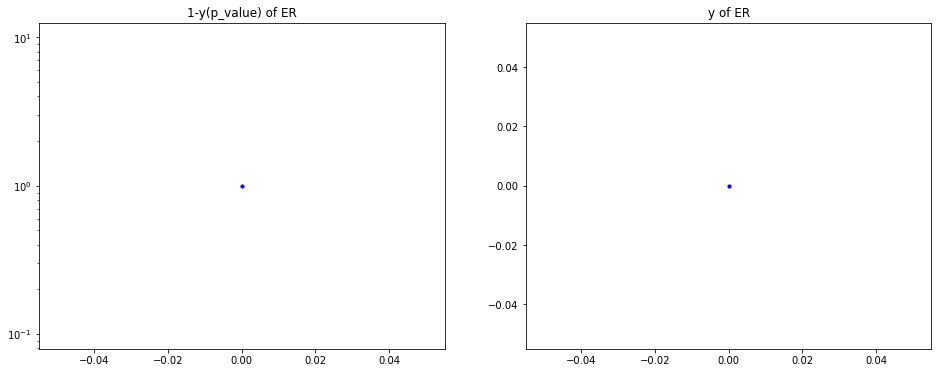

In [32]:
# AT
for i in range(len(classes_pred[:-1])):
    data_i = data_distance(data(df_comb,classes_pred[:-1][i]))
    print(data_i)
    sigmoids_for_class(data_i, classes_pred[:-1][i], np.mean(data_i), functions, colors)

For  ER  :
curve_fit parameter on  logis:  [0.84311907 4.19071931]
curve_fit parameter on  t:  [0.84311909 2.09535952]
curve_fit parameter on  arc:  [0.83423092 4.26169456]
curve_fit parameter on :  [0.84168112 1.71054944]
curve_fit parameter on  :  [0.84521007 1.77601156]
curve_fit parameter on  alge:  [0.81059285 0.37485748]
curve_fit parameter on  arctan:  [0.83920398 2.03068049 0.77663912]
curve_fit parameter on  Gompe:  [1.98391638 2.84785168]


/var/folders/cl/y520x4ts6zngnmzdyy7mjx280000gn/T/ipykernel_82864/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/var/folders/cl/y520x4ts6zngnmzdyy7mjx280000gn/T/ipykernel_82864/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


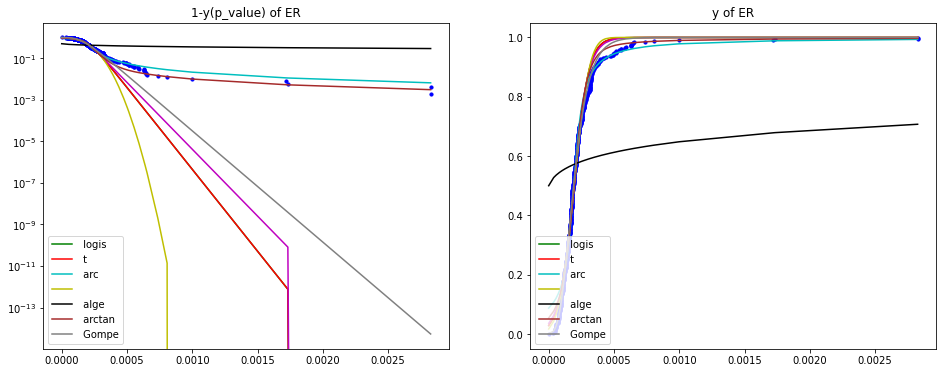

For  ERDD  :
curve_fit parameter on  logis:  [0.85264818 5.27442736]
curve_fit parameter on  t:  [0.85264818 2.63721356]
curve_fit parameter on  arc:  [0.84159729 5.2360311 ]
curve_fit parameter on :  [0.85104345 2.14212733]
curve_fit parameter on  :  [0.85481524 2.25043793]
curve_fit parameter on  alge:  [0.82123344 0.32998099]
curve_fit parameter on  arctan:  [0.84766261 2.6031922  0.74217325]
curve_fit parameter on  Gompe:  [2.69934044 3.65853708]


/var/folders/cl/y520x4ts6zngnmzdyy7mjx280000gn/T/ipykernel_82864/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/var/folders/cl/y520x4ts6zngnmzdyy7mjx280000gn/T/ipykernel_82864/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


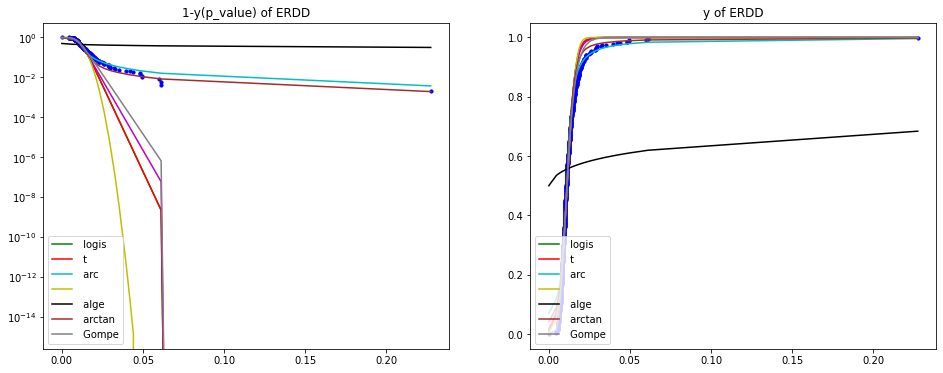

For  GEO  :
curve_fit parameter on  logis:  [0.92567258 5.02786581]
curve_fit parameter on  t:  [0.92567258 2.51393299]
curve_fit parameter on  arc:  [0.91827611 4.96155565]
curve_fit parameter on :  [0.92468564 2.04075416]
curve_fit parameter on  :  [0.92697128 2.14720338]
curve_fit parameter on  alge:  [0.89825336 0.31601685]
curve_fit parameter on  arctan:  [0.92384104 2.19253734 0.89941531]
curve_fit parameter on  Gompe:  [2.78535962 3.46467316]


/var/folders/cl/y520x4ts6zngnmzdyy7mjx280000gn/T/ipykernel_82864/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/var/folders/cl/y520x4ts6zngnmzdyy7mjx280000gn/T/ipykernel_82864/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


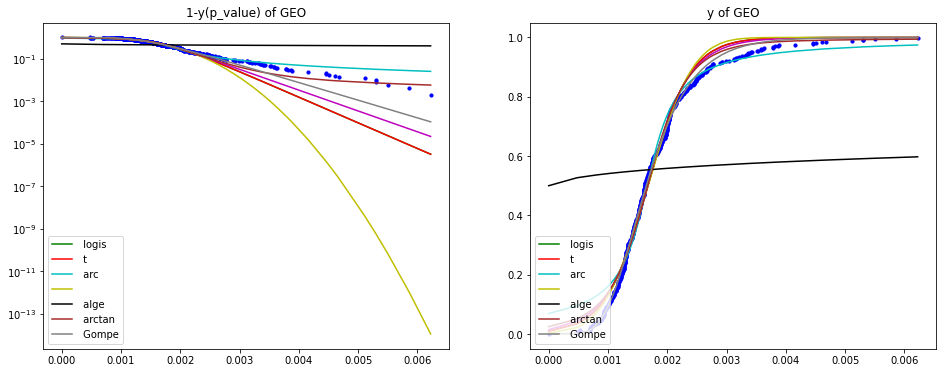

For  GEOGD  :
curve_fit parameter on  logis:  [0.59902211 3.81942545]
curve_fit parameter on  t:  [0.5990214  1.90971955]
curve_fit parameter on  arc:  [0.56556671 3.89114809]
curve_fit parameter on :  [0.59479969 1.54691347]
curve_fit parameter on  :  [0.60477311 1.63196588]
curve_fit parameter on  alge:  [0.50220547 0.50188954]
curve_fit parameter on  arctan:  [0.56755131 3.14676002 0.20901483]
curve_fit parameter on  Gompe:  [1.23843574 2.78103807]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


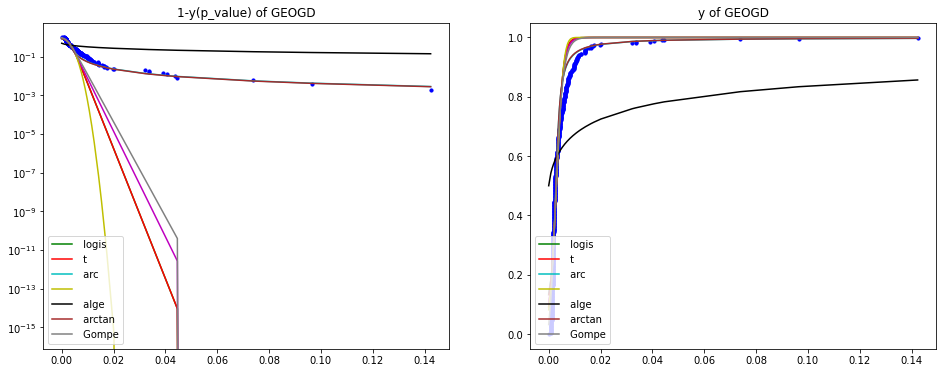

For  HGG  :
curve_fit parameter on  logis:  [0.60234175 3.69604923]
curve_fit parameter on  t:  [0.60234075 1.84803365]
curve_fit parameter on  arc:  [0.56424461 3.79777107]
curve_fit parameter on :  [0.59777389 1.49631735]
curve_fit parameter on  :  [0.60852172 1.57958966]
curve_fit parameter on  alge:  [0.49483972 0.50222967]
curve_fit parameter on  arctan:  [0.56577567 3.21240763 0.16417209]
curve_fit parameter on  Gompe:  [1.20607767 2.71547498]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


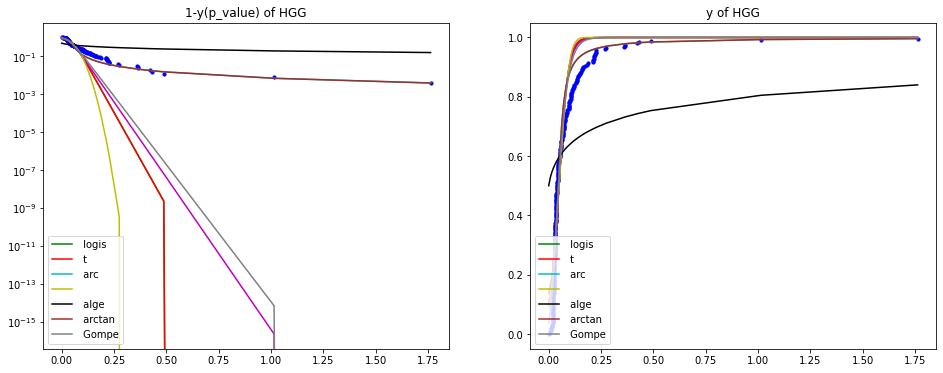

For  SF  :
curve_fit parameter on  logis:  [0.92382817 5.72415162]
curve_fit parameter on  t:  [0.92382818 2.86207602]
curve_fit parameter on  arc:  [0.91585135 5.72564899]
curve_fit parameter on :  [0.92271124 2.32789364]
curve_fit parameter on  :  [0.92525402 2.43801103]
curve_fit parameter on  alge:  [0.90051315 0.3028076 ]
curve_fit parameter on  arctan:  [0.92076705 2.736207   0.78523145]
curve_fit parameter on  Gompe:  [3.21352937 3.92862466]


/var/folders/cl/y520x4ts6zngnmzdyy7mjx280000gn/T/ipykernel_82864/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/var/folders/cl/y520x4ts6zngnmzdyy7mjx280000gn/T/ipykernel_82864/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


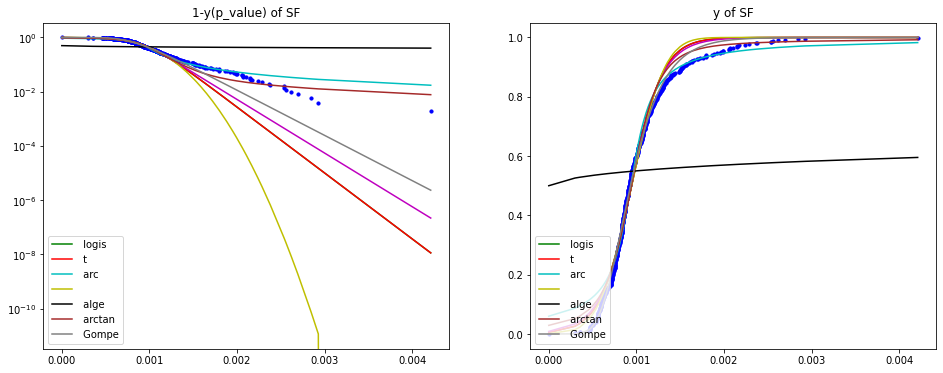

For  SFDD  :
curve_fit parameter on  logis:  [0.63384824 4.35227301]
curve_fit parameter on  t:  [0.63384823 2.17613672]
curve_fit parameter on  arc:  [0.61318326 4.34916869]
curve_fit parameter on :  [0.63081395 1.76465453]
curve_fit parameter on  :  [0.63834278 1.85598466]
curve_fit parameter on  alge:  [0.58616421 0.45390533]
curve_fit parameter on  arctan:  [0.61458628 3.31074667 0.27284923]
curve_fit parameter on  Gompe:  [1.52828595 3.06884237]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


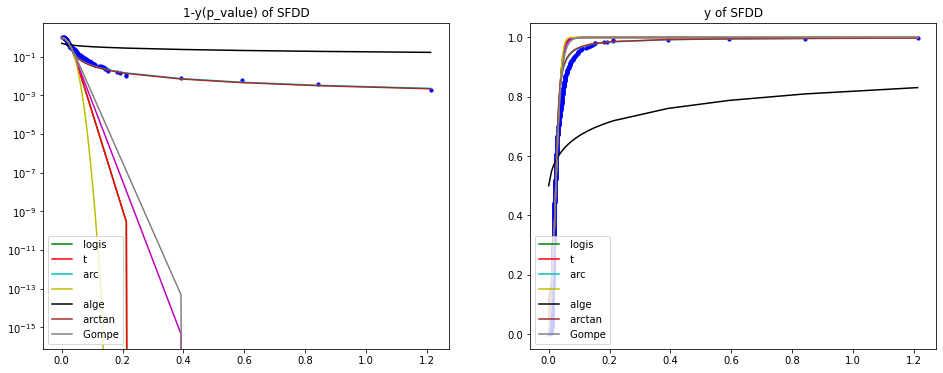

For  Sticky  :
curve_fit parameter on  logis:  [0.96273333 6.27012499]
curve_fit parameter on  t:  [0.96273328 3.13506036]
curve_fit parameter on  arc:  [0.95839206 6.22468997]
curve_fit parameter on :  [0.96212333 2.54920467]
curve_fit parameter on  :  [0.96353124 2.6738718 ]
curve_fit parameter on  alge:  [0.94541365 0.27545599]
curve_fit parameter on  arctan:  [0.96224326 2.50894231 1.02296407]
curve_fit parameter on  Gompe:  [3.71578309 4.30201012]


/var/folders/cl/y520x4ts6zngnmzdyy7mjx280000gn/T/ipykernel_82864/217763432.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/var/folders/cl/y520x4ts6zngnmzdyy7mjx280000gn/T/ipykernel_82864/217763432.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


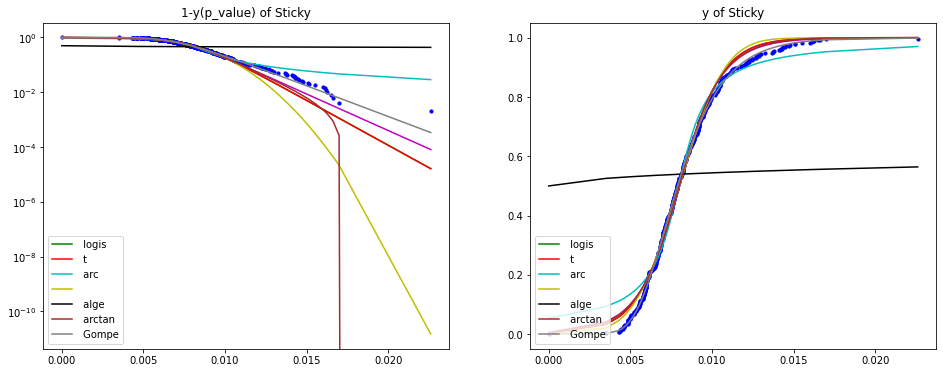

In [ ]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_CE,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], np.mean(data_i), functions, colors)

### Binning

In [ ]:
# binning first, add (0,0) at the front later when calculate y
#make it smooth

def data_binning(data):
    
    x = np.sort(data) 
    N = len(x)                   # e.g N = 500, sqrt(500)=22.3
    lower = int(np.floor(np.sqrt(N))) # 22
    upper = int(np.ceil(np.sqrt(N)))  # 23 as total #of bin
    
    if lower*upper >= N:
        small_bin_num = int(lower*upper - N)  # 22*23 - 500 = 6
        small_bin_size = int(lower - 1)  # 21
        large_bin_size = lower
    else: # HGG -> sqrt(252) = 15.8
        small_bin_num = int(upper**2 - N) # 16*16-252 =4
        small_bin_size = lower  # 15
        large_bin_size = upper
    
    large_bin_num = int(upper - small_bin_num) # 23-6 = 17

    # small_bin_size*small_bin_num + lower*large_bin_num = N

    bin_count = [large_bin_size]*large_bin_num + [small_bin_size]*small_bin_num  # [22..*17, 21..*6,]
    print("items in each bin: ", bin_count)
    binned_data = []
    i = 0
    for count in bin_count:
        binned_data.append(np.mean(x[i:i+count]))
        i += count
    
    return binned_data


def binning_xy(binned_data):
    x = np.concatenate(([0],binned_data))
    y = np.zeros((x.shape))
    
    for i in range(1,len(x)):
        y[i] = i/len(x)
        
    return x,y
 

#### AT

In [ ]:
# for i in range(len(classes[:-1])):
#     data_i = data_distance(data(df_comb,classes[:-1][i]))
#     sigmoids_for_class(data_i, classes[:-1][i], factors[i], functions, colors,binning=True)

#### CE

In [ ]:
# for i in range(len(classes[:-1])):
#     data_i = data_distance(data(df_CE,classes[:-1][i]))
#     sigmoids_for_class(data_i, classes[:-1][i], factors[i], functions, colors,binning=True)

In [ ]:
# arctan_popt

In [ ]:
def euclid(origin, other):
  return np.sum((origin - other) ** 2)**(1/2)

def NN_distance(ref_point, data):
  nearest_distance = 1e999
  for point in data:
    if euclid(ref_point, point) < nearest_distance: 
      nearest_distance = euclid(ref_point, point)
  return nearest_distance

NN_dict = {}

In [ ]:
original = df_comb[df_comb['class'] == 'Original']
for target in arctan_popt:
  nearest_distance = NN_distance(original.drop(['class'], axis = 1).to_numpy(), df_comb[df_comb['class'] == f'{target}'].drop(['class'], axis = 1).to_numpy())
  #NN_dict["arctan_GD"] = nearest_distance
  #print(NN_dict)
  #print(nearest_distance)
  print(arctan_GD(nearest_distance,*arctan_popt[f'{target}']))
  #least square fittinhg, make it as a library, can only have dataset with numbers, no images
  #different variables, weigh in a approtate place
  #create a library, then find a new data never see before, test it 
  #uci ml repository
#print(NN_dict)

0.9664408249707113
0.9718401609077627
0.9816160770959803
0.9426719231381333
0.9409854586707858
0.9748968260379774
0.7602980007563807
0.9831163142312822


In [ ]:
original = df_comb[df_comb['class'] == 'Original']
for target in ERF_popt:
    nearest_distance1 = NN_distance(original.drop(['class'], axis = 1).to_numpy(), df_comb[df_comb['class'] == f'{target}'].drop(['class'], axis = 1).to_numpy())
    NN_dict["ERF"] = nearest_distance
    #print(nearest_distance1)
    print(ERF(nearest_distance1,*ERF_popt[f'{target}']))

0.9979047912685103
0.9998275832386696
0.9993566068852484
0.9989676231439084
0.9985992160995096
0.9997957519884658
0.7192790381298867
0.9952407075756056


In [ ]:
original = df_comb[df_comb['class'] == 'Original']
for target in arc_popt:
    nearest_distance1 = NN_distance(original.drop(['class'], axis = 1).to_numpy(), df_comb[df_comb['class'] == f'{target}'].drop(['class'], axis = 1).to_numpy())
    NN_dict["arctan"] = nearest_distance
    print(arctan(nearest_distance1,*arc_popt[f'{target}']))

0.9359875132601504
0.9470633592822022
0.9406674900804892
0.9411454551811921
0.940078363767447
0.9467643059143869
0.7610020301402236
0.9272693697686288


In [ ]:
original = df_comb[df_comb['class'] == 'Original']
for target in logistic_popt:
    nearest_distance1 = NN_distance(original.drop(['class'], axis = 1).to_numpy(), df_comb[df_comb['class'] == f'{target}'].drop(['class'], axis = 1).to_numpy())
    NN_dict["logistic"] = nearest_distance
    print(logistic(nearest_distance1,*arc_popt[f'{target}']))

0.9926480211877003
0.9974202961530098
0.995045886244151
0.9952584725824024
0.9947757400261619
0.9973310677286604
0.7449071931305266
0.9866147876810004


In [ ]:
original = df_comb[df_comb['class'] == 'Original']
for target in tanh_popt:
    nearest_distance1 = NN_distance(original.drop(['class'], axis = 1).to_numpy(), df_comb[df_comb['class'] == f'{target}'].drop(['class'], axis = 1).to_numpy())
    NN_dict["tanh"] = nearest_distance
    print(tanh(nearest_distance1,*arc_popt[f'{target}']))

0.9999451477927102
0.9999933107042909
0.9999752123721757
0.9999773037080872
0.9999724204476746
0.9999928386763786
0.8950376829158593
0.9998159756214724


In [ ]:
original = df_comb[df_comb['class'] == 'Original']
for target in gd_popt:
    nearest_distance1 = NN_distance(original.drop(['class'], axis = 1).to_numpy(), df_comb[df_comb['class'] == f'{target}'].drop(['class'], axis = 1).to_numpy())
    NN_dict["gd"] = nearest_distance
    print(GD(nearest_distance1,*arc_popt[f'{target}']))

0.9999650780847722
0.9999957414336016
0.9999842193148545
0.9999855507638673
0.9999824418274346
0.9999954409271374
0.925682158466362
0.999882824880276


In [ ]:
original = df_comb[df_comb['class'] == 'Original']
for target in algebra_popt:
    nearest_distance1 = NN_distance(original.drop(['class'], axis = 1).to_numpy(), df_comb[df_comb['class'] == f'{target}'].drop(['class'], axis = 1).to_numpy())
    NN_dict["algebra"] = nearest_distance
    print(algebra(nearest_distance1,*arc_popt[f'{target}']))

0.9938896072214924
0.9973687238427779
0.996724395244702
0.9906829998094988
0.9900035957191846
0.9981185283485854
0.8904700305487386
0.9965215106654319


In [ ]:
original = df_comb[df_comb['class'] == 'Original']
for target in Gompertz_popt:
    nearest_distance1 = NN_distance(original.drop(['class'], axis = 1).to_numpy(), df_comb[df_comb['class'] == f'{target}'].drop(['class'], axis = 1).to_numpy())
    NN_dict["Gompertz"] = nearest_distance
    print(Gompertz(nearest_distance1,*arc_popt[f'{target}']))

0.9995127127585773
0.9999268183992662
0.9998690163380536
0.9990717825763856
0.9989173818641494
0.9999646924569149
0.9570263517249185
0.9999092566966141


In [ ]:
print(Gompertz_popt)

{'ER': array([1.98391638, 2.84785168]), 'ERDD': array([2.69934044, 3.65853708]), 'GEO': array([2.78535962, 3.46467316]), 'GEOGD': array([1.23843574, 2.78103807]), 'HGG': array([1.20607767, 2.71547498]), 'SF': array([3.21352937, 3.92862466]), 'SFDD': array([1.52828595, 3.06884237]), 'Sticky': array([3.71578309, 4.30201012])}
